In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

# Create table and import data

In [3]:
%%sql

DROP TYPE IF EXISTS expansion;
CREATE TYPE expansion AS ENUM ('KTK', 'LCI', 'WOE', 'LTR', 'MOM', 'SIR', 'ONE', 'BRO', 'DMU', 'HBG', 'SNC', 'NEO', 'VOW', 'MID', 'AFR', 'STX', 'KHM');
DROP TYPE IF EXISTS event_type;
CREATE TYPE event_type AS ENUM ('PremierDraft', 'TradDraft', 'Sealed', 'TradSealed');
DROP TYPE IF EXISTS rank;
CREATE TYPE rank AS ENUM ('silver', 'bronze', 'None', 'gold', 'platinum', 'diamond', 'mythic');
DROP TYPE IF EXISTS color;
CREATE TYPE color AS ENUM ('RG', 'UBG', 'WUB', 'UBR', 'WUBG', 'BG', 'WG', 'WBG', 'WUBRG', 'UR', 'UB', 'WBR', 'WRG', 'None', 'BR', 'WUBR', 'G', 'WR', 'W', 'WU', 'WB', 'WUR', 'WUG', 'WBRG', 'BRG', 'U', 'URG', 'UBRG', 'UG', 'B', 'R', 'WURG');

,Success


In [4]:
%%sql

DROP TABLE IF EXISTS game;

# https://www.17lands.com/history/<draft_id>/<match_number - 1>/<game_number - 1>
CREATE TABLE game (
    expansion expansion NOT NULL,
    event_type event_type NOT NULL,
    draft_id VARCHAR NOT NULL,
    draft_time TIMESTAMP_S NOT NULL,
    game_time TIMESTAMP_S NOT NULL,
    build_index TINYINT NOT NULL,
    match_number TINYINT NOT NULL,
    game_number TINYINT NOT NULL,
    rank rank,
    opp_rank rank NOT NULL,
    main_colors color NOT NULL,
    splash_colors color,
    on_play BOOLEAN NOT NULL,
    num_mulligans TINYINT NOT NULL,
    opp_num_mulligans TINYINT NOT NULL,
    opp_colors color,
    num_turns TINYINT NOT NULL,
    won BOOLEAN NOT NULL,
    user_n_games_bucket INTEGER NOT NULL,
    user_game_win_rate_bucket DOUBLE,
)

,Success


In [5]:
%%sql

INSERT INTO
    game
BY NAME
SELECT
    expansion, event_type, draft_id, draft_time, game_time, build_index, match_number, game_number, rank, opp_rank, main_colors, splash_colors, on_play, num_mulligans, opp_num_mulligans, opp_colors, num_turns, won, user_n_games_bucket, user_game_win_rate_bucket
FROM
    'https://17lands-public.s3.amazonaws.com/analysis_data/game_data/game_data_public.LCI.PremierDraft.csv.gz'

,Success


In [6]:
%%sql

DROP INDEX IF EXISTS game_draft_match_game;
CREATE UNIQUE INDEX game_draft_match_game ON game (draft_id, match_number, game_number);

DROP INDEX IF EXISTS game_rank;
CREATE INDEX game_rank ON game (rank);

DROP INDEX IF EXISTS game_main_colors;
CREATE INDEX game_main_colors ON game (main_colors);

DROP INDEX IF EXISTS game_splash_colors;
CREATE INDEX game_splash_colors ON game (splash_colors);

DROP INDEX IF EXISTS game_on_play;
CREATE INDEX game_on_play ON game (on_play);

DROP INDEX IF EXISTS game_user_n_games_bucket;
CREATE INDEX game_user_n_games_bucket ON game (user_n_games_bucket);

DROP INDEX IF EXISTS game_user_win_rate_bucket;
CREATE INDEX game_user_win_rate_bucket ON game (user_game_win_rate_bucket);

,Success


# Check distribution and determine the threshold to filter target players

Target user

1. Win-rate is high enough.
2. Play enough many games so the win-rate is meaningful.

## User games distribution and threshold

<Axes: title={'center': 'User Games Distribution'}, xlabel='user_n_games_bucket'>

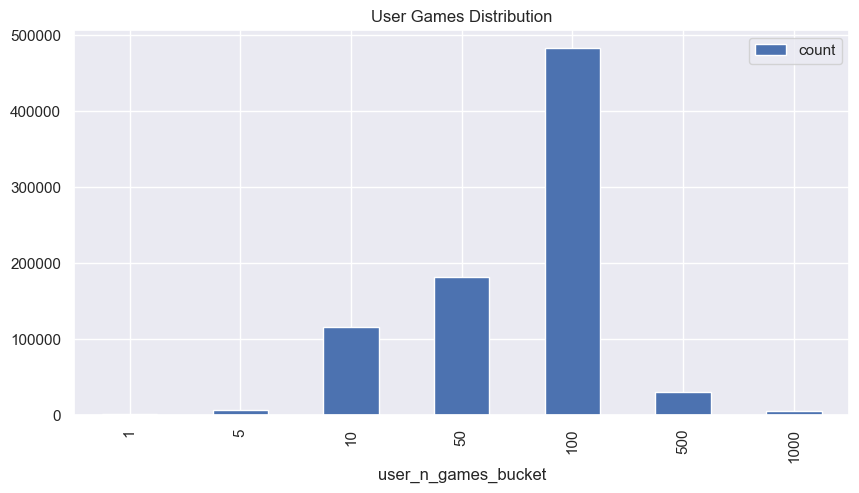

In [19]:
user_n_games = %sql SELECT user_n_games_bucket, COUNT(*) AS count FROM game WHERE user_n_games_bucket IS NOT NULL GROUP BY user_n_games_bucket ORDER BY user_n_games_bucket
user_n_games.plot.bar(x='user_n_games_bucket', y='count', figsize=(10, 5), title='User Games Distribution')

In [20]:
%%sql

SELECT
    percentile_cont (0.5) WITHIN GROUP (ORDER BY user_n_games_bucket) AS median,
    percentile_cont (0.75) WITHIN GROUP (ORDER BY user_n_games_bucket) AS P75,
    percentile_cont (0.80) WITHIN GROUP (ORDER BY user_n_games_bucket) AS P80,
    percentile_cont (0.85) WITHIN GROUP (ORDER BY user_n_games_bucket) AS P85,
    percentile_cont (0.90) WITHIN GROUP (ORDER BY user_n_games_bucket) AS P90,
    percentile_cont (0.95) WITHIN GROUP (ORDER BY user_n_games_bucket) AS P95,
    percentile_cont (0.99) WITHIN GROUP (ORDER BY user_n_games_bucket) AS P99,
FROM game

,median,P75,P80,P85,P90,P95,P99
0,100.0,100.0,100.0,100.0,100.0,100.0,500.0


In [22]:
user_n_games_threshold = 100

## User win-rate distribution and threshold

<Axes: title={'center': 'User Game Win Rate Distribution'}, xlabel='user_game_win_rate_bucket'>

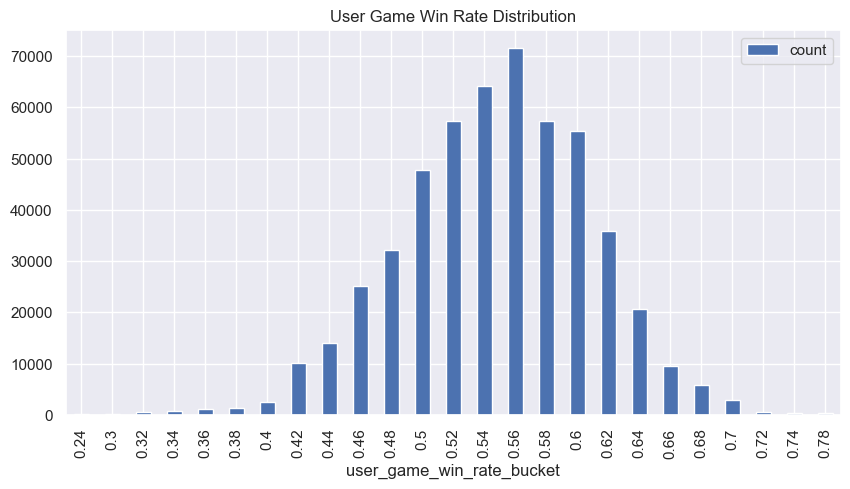

In [23]:
user_game_win_rates = %sql SELECT user_game_win_rate_bucket, COUNT(*) AS count FROM game WHERE user_game_win_rate_bucket IS NOT NULL AND user_n_games_bucket >= {{ user_n_games_threshold }} GROUP BY user_game_win_rate_bucket ORDER BY user_game_win_rate_bucket
user_game_win_rates = user_game_win_rates.round(2)
user_game_win_rates.plot.bar(x='user_game_win_rate_bucket', y='count', figsize=(10, 5), title='User Game Win Rate Distribution')

In [24]:
%%sql

SELECT
    percentile_cont (0.5) WITHIN GROUP (ORDER BY user_game_win_rate_bucket) AS median,
    percentile_cont (0.75) WITHIN GROUP (ORDER BY user_game_win_rate_bucket) AS P75,
    percentile_cont (0.80) WITHIN GROUP (ORDER BY user_game_win_rate_bucket) AS P80,
    percentile_cont (0.85) WITHIN GROUP (ORDER BY user_game_win_rate_bucket) AS P85,
    percentile_cont (0.90) WITHIN GROUP (ORDER BY user_game_win_rate_bucket) AS P90,
    percentile_cont (0.95) WITHIN GROUP (ORDER BY user_game_win_rate_bucket) AS P95,
    percentile_cont (0.99) WITHIN GROUP (ORDER BY user_game_win_rate_bucket) AS P99,
FROM game
WHERE user_n_games_bucket >= {{ user_n_games_threshold }}

,median,P75,P80,P85,P90,P95,P99
0,0.56,0.6,0.6,0.6,0.62,0.64,0.68


In [ ]:
# Set a reasonable percentile to calculate the user_win_rate_threshold
top_user_win_rate_percentile = 0.85

In [26]:
threshold_df = %sql SELECT percentile_cont ({{ top_user_win_rate_percentile }}) WITHIN GROUP (ORDER BY user_game_win_rate_bucket) AS threshold FROM game WHERE user_n_games_bucket >= {{ user_n_games_threshold }}
win_rate_threshold = threshold_df['threshold'][0]
win_rate_threshold

0.6

```SQL
WHERE user_game_win_rate_bucket >= {{ win_rate_threshold }} AND user_n_games_bucket >= {{ user_n_games_threshold }}
```

# Analysis

<Axes: title={'center': 'Main Colors Distribution'}, ylabel='count'>

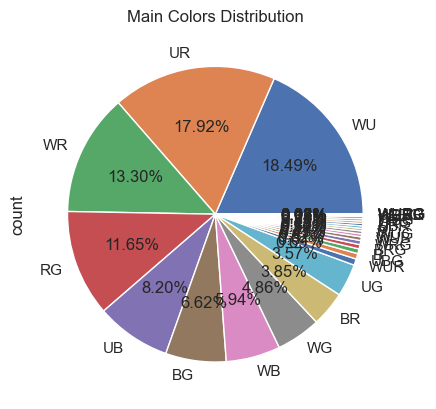

In [27]:
top_game = %sql SELECT main_colors, COUNT(*) AS count FROM game WHERE user_game_win_rate_bucket >= {{ win_rate_threshold }} AND user_n_games_bucket >= {{ user_n_games_threshold }} GROUP BY main_colors ORDER BY count DESC
top_game.set_index('main_colors', inplace=True)
top_game.plot.pie(y='count', autopct='%.2f%%', title='Main Colors Distribution', legend=False)